In [1]:
#Make sure fastai is up to date. 
!curl -s https://course.fast.ai/setup/colab | bash

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [2]:
#Read in standard data science libraries.
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path

In [27]:
#All pictures used are in jpg format, so when executing some cells we get the following:

#/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images.

#This warning is telling us that there are images with a limited number of colors (a "palette") that also have transparency information (i.e., some parts of the image are transparent). 
#To handle transparency properly, PIL is recommending that these images be converted to a different format called RGBA, which includes an additional channel for transparency information.
#Transparency can potentially interfere with deep learning with images, because transparent pixels in an image typically have an alpha channel value of zero, which can result in artifacts or errors during image processing.
#In the FastAI library (the one we are working with), images with alpha channels are automatically converted to RGBA format, where the alpha channel is properly handled.
#So in this case transparency should not be an issue. That is why we are ignoring these warnings.

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
#Import google drive package.
from  google.colab import drive

In [28]:
#Import FastAi entire library.
from fastai.vision.all import *


In [6]:
#Connect workbook to google drive folder to access images. 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#Save path to project folder. 
root_path = 'gdrive/My Drive/AI_Projects/'

In [15]:
#Save path for folder that contains images and variable tags. 
proj_path = 'gdrive/My Drive/AI_Projects/sportscars_recognition/cars'

In [16]:
#Make folder names. 
folders = ['ferrari_f40','bugatti_chiron','corvette_c5_2000','ford_mustang_gt350','mclaren_720s_spider','lamborghini_huracan','porsche_930_turbo','toyota_supra_mark_IV','porsche_918_spyder','lamborghini_veneno']

In [17]:
#Save fastai path. 
p_path = Path(proj_path)

In [18]:
#Create image data bunch with 80/20 train test split.
np.random.seed(42)
data = ImageDataLoaders.from_folder(p_path, train=".", valid_pct=0.2,
                                     item_tfms=Resize(460),
                                     batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)])

In [19]:
data.vocab

['bugatti_chiron', 'corvette_c5_2000', 'ferrari_f40', 'ford_mustang_gt350', 'lamborghini_huracan', 'lamborghini_veneno', 'mclaren_720s_spider', 'porsche _918_spyder', 'porsche_930_turbo', 'toyota_supra_mark_IV']

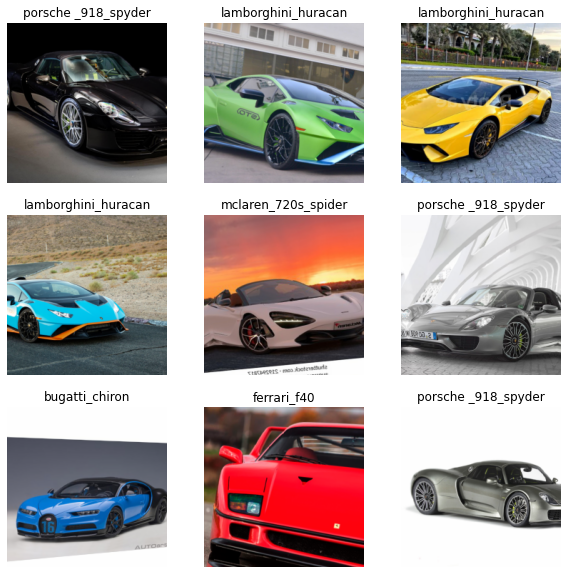

In [20]:
#Show sample of images 
data.show_batch(nrows=3, figsize=(10,10))

In [21]:
data.vocab, data.c, len(data.train_ds), len(data.valid_ds)

(['bugatti_chiron', 'corvette_c5_2000', 'ferrari_f40', 'ford_mustang_gt350', 'lamborghini_huracan', 'lamborghini_veneno', 'mclaren_720s_spider', 'porsche _918_spyder', 'porsche_930_turbo', 'toyota_supra_mark_IV'],
 10,
 785,
 196)

In [22]:
#Create cnn_learner object.
# use resnet 34 for transfer learning. 
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

#cnn_learner is a function from the fastai library that creates a convolutional neural network (CNN) for image classification tasks. 
#It takes a DataLoaders object (in this case, data) containing the training and validation datasets as its first argument, 
#and the architecture of the pre-trained model to use for transfer learning as the second argument (in this case, models.resnet34).

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [23]:
#Train 8 epochs of the model. 
learn.fit_one_cycle(8)

In [24]:
#Save model.
learn.save('model1_34')

#Get the path to the saved model.
path_to_model = Path(learn.path)/'models'/'model1_34.pth'

In [25]:
#Unfreeze model. The code learn.unfreeze() unfreezes all the layers of the pre-trained model, allowing them to be fine-tuned during training.
learn.unfreeze()

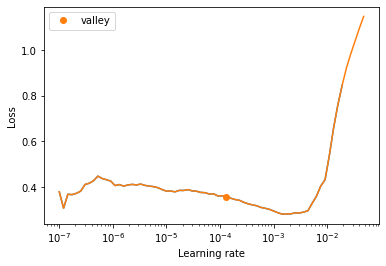

In [26]:
#learn.lr_find() is a method from the fastai library which helps to find a good learning rate to use during training.
#It works by training the model for one epoch while gradually increasing the learning rate. It then plots the loss function versus the learning rate on a logarithmic scale.
#The idea is to identify the steepest part of the plot, which corresponds to the fastest decrease in the loss, and choose a learning rate within that range. 
#This can help to train the model more efficiently and improve its performance.

learn.lr_find()
plt.plot(learn.recorder.lrs, learn.recorder.losses)
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.show()

In [29]:
# fit whole model with new learning rates 
learn.fit_one_cycle(2, lr_max=1e-4, wd=.001)

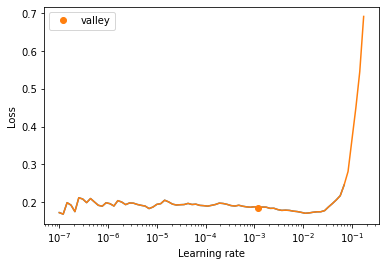

In [30]:
#learn.freeze() freezes all but the last layer of the model, which means that only the last layer can be trained.
# This is useful for transfer learning when you want to keep the pre-trained weights of the earlier layers fixed and only fine-tune the final layers for a new task.

learn.freeze()
learn.lr_find()
plt.plot(learn.recorder.lrs, learn.recorder.losses)
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.show()

In [31]:
#Save new model.
learn.save('model2_34')

#Get the path to the saved model.
path_to_model = Path(learn.path)/'models'/'model2_34.pth'

In [32]:
learn.load('model2_34')
interp = ClassificationInterpretation.from_learner(learn)

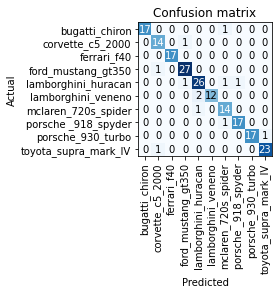

In [33]:
#plot results of model on validation set 
interp.plot_confusion_matrix()

#A confusion matrix is a table that summarizes the performance of a classification model by comparing the actual labels of a set of samples with the labels predicted by the model. 
#The rows of the confusion matrix correspond to the actual labels, while the columns correspond to the  predicted labels. 
#The diagonal elements of the matrix represent the number of correct predictions for each class, while the off-diagonal elements represent the number of misclassifications.

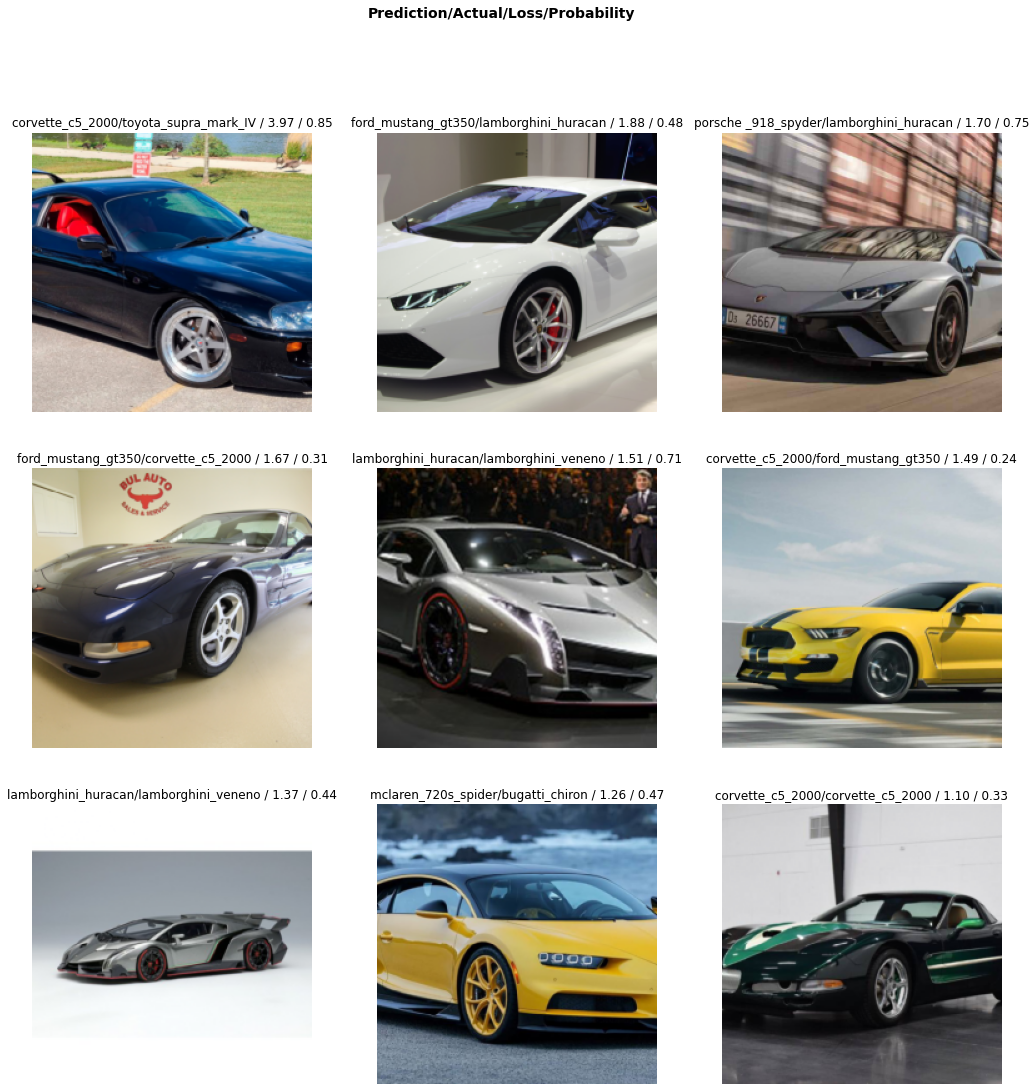

In [71]:
# plot top losses (most wrong)
interp.plot_top_losses(9, figsize=(17.5,17.5))

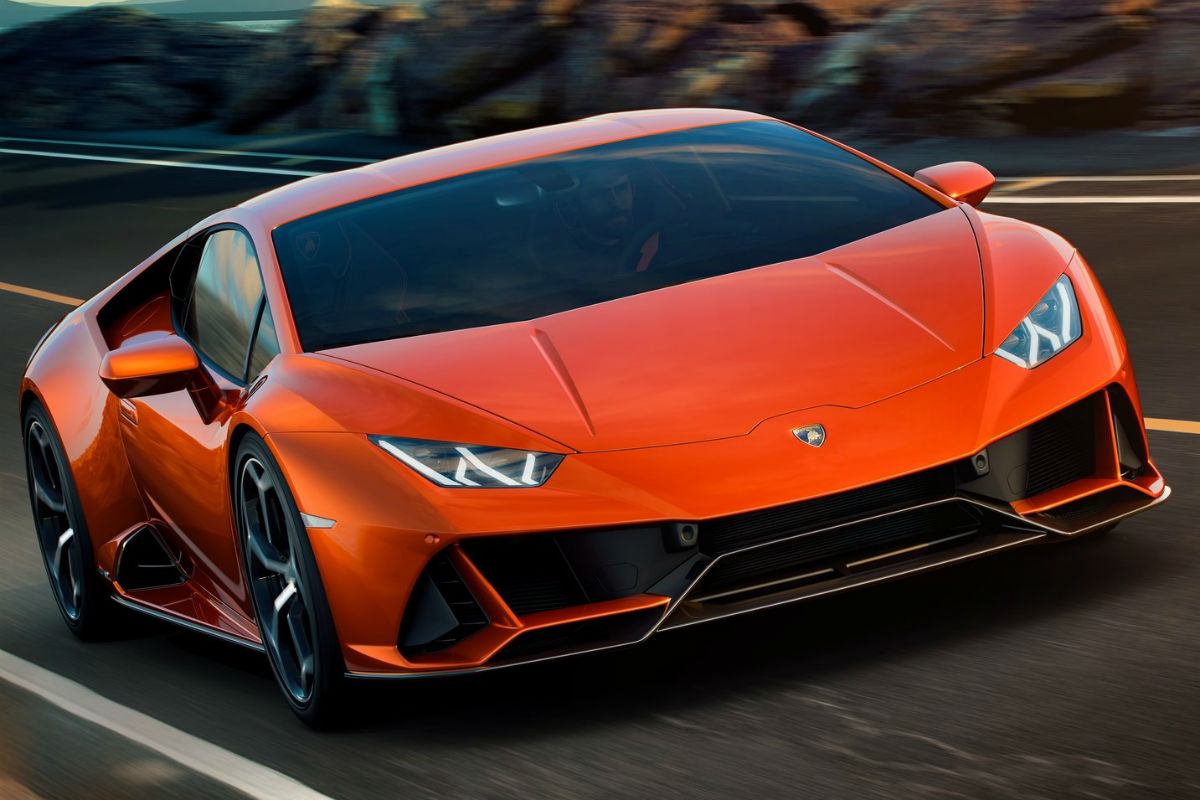

In [40]:
#Let's test now the model with some images outside of the dataset to see if it can predict them correctly.

from PIL import Image

img1_path = Path(root_path) / 'sportscars_recognition' / 'cars_valid' / 'huracan.jpg'
img1 = Image.open(img1_path)
img1


In [41]:
pred_class,pred_idx,outputs = learn.predict(img1)
pred_class

'lamborghini_huracan'

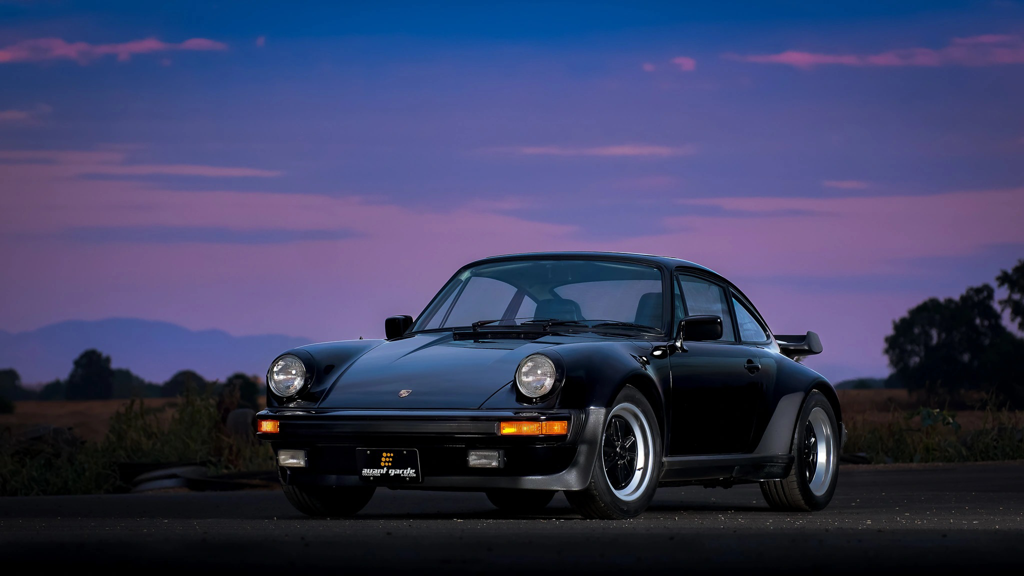

In [62]:
img2_path = Path(root_path) / 'sportscars_recognition' / 'cars_valid' / 'porsche930.jpg'
img2 = Image.open(img2_path)

# Resize the image to 50% of its original size
width, height = img2.size
new_size = (int(width * 0.5), int(height * 0.5))
img2 = img2.resize(new_size)

img2.show()

In [63]:
pred_class,pred_idx,outputs = learn.predict(img2)
pred_class

'porsche_930_turbo'

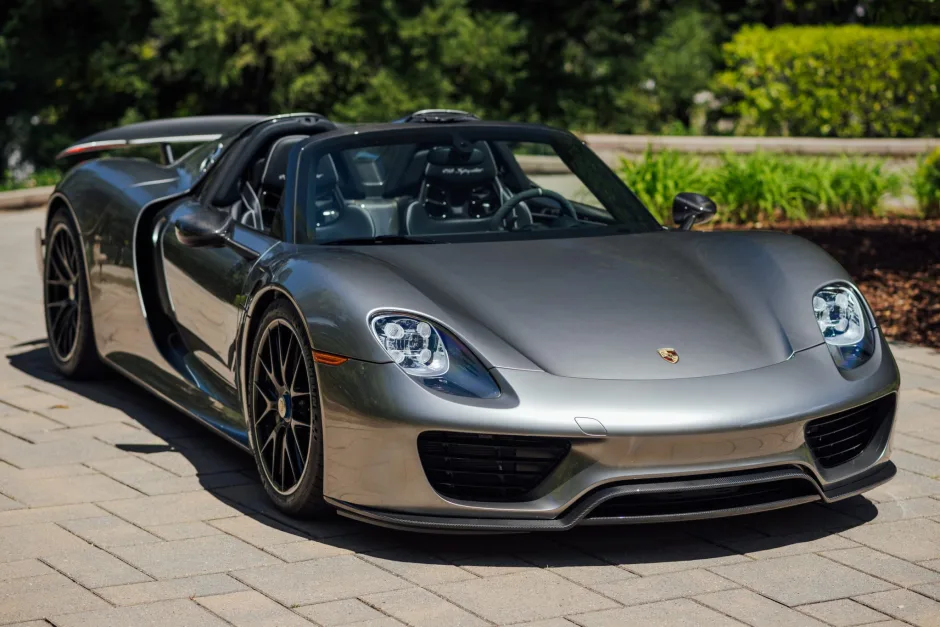

In [45]:
img3_path = Path(root_path) / 'sportscars_recognition' / 'cars_valid' / 'spyder.jpg'
img3 = Image.open(img3_path)
img3

In [46]:
pred_class,pred_idx,outputs = learn.predict(img3)
pred_class

'porsche _918_spyder'

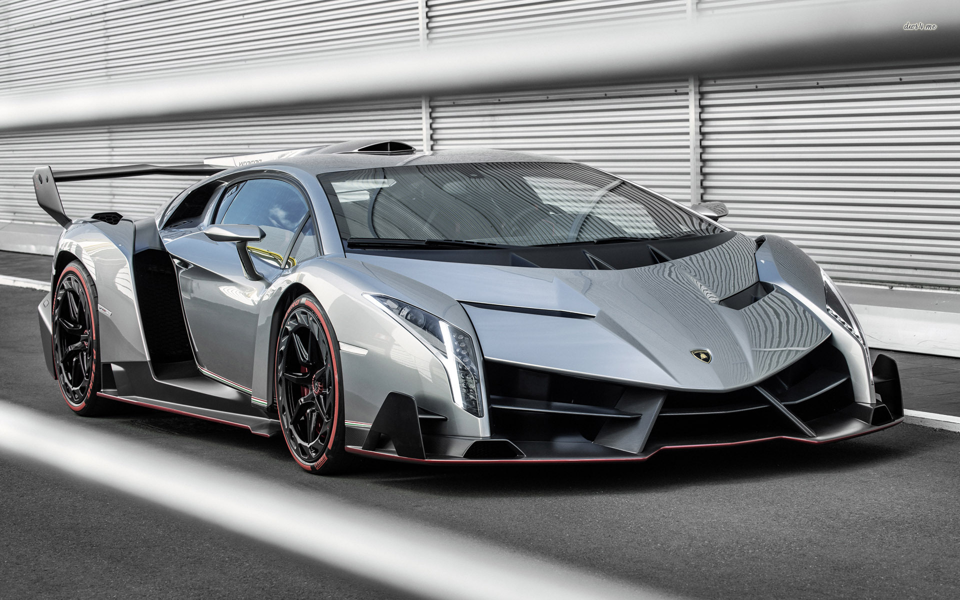

In [67]:
img4_path = Path(root_path) / 'sportscars_recognition' / 'cars_valid' / 'veneno.jpg'
img4 = Image.open(img4_path)

# Resize the image to 50% of its original size
width, height = img4.size
new_size = (int(width * 0.5), int(height * 0.5))
img4 = img4.resize(new_size)

img4.show()

In [68]:
pred_class,pred_idx,outputs = learn.predict(img4)
pred_class

'lamborghini_veneno'

In [72]:
#Final state of the model after tuning: able to predict the car brand with 94% accuracy.